# Convolutional Neural Network - Pattern Recognition in Stock Markets

In [130]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
#import pandas_datareader as pdr
import csv
import warnings
from keras import layers
from keras import models


N = 400

In [2]:
%matplotlib inline

In [3]:
#hide all warnings
#warnings.filterwarnings('ignore')

#show all warnings just once
warnings.filterwarnings(action='once')

In [4]:
from helpers import delete_nans, get_returns, plot_example_returns, tickers, get_data_subsets#, data_loader

/Users/SirLukeSchande/.pyenv/versions/3.6.10/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/SirLukeSchande/.pyenv/versions/3.6.10/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/SirLukeSchande/.pyenv/versions/3.6.10/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/SirLukeSchande/.pyenv/versions/3.6.10/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/SirLukeSchande/.pyenv

# Download Data

In [5]:
begin = "2007-01-01"
finish = "2017-01-01"

#data_loader(begin, finish, 'returns.csv')

In [131]:
returns = get_returns('returns.csv', N)

Number of columns with only NaNs: 0
Number of lines with only NaNs: 0
Number of NaNs: 0
shape Dataframe: (2518, 400)


## Helper Functions

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,AFL,A,APD,AKAM,ALK,ALB,ARE,ALXN,ALGN
Date,,,,,,,,,,,,,,,,,,,,
2007-01-03,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-01-04,-0.003961,0.018991,0.0,0.021352,0.022540,0.008158,0.022545,0.013832,0.006464,0.000456,-0.010861,-0.011027,0.003207,-0.021972,0.023622,0.019508,-0.004584,-0.001686,0.002955,0.018727
2007-01-05,-0.006799,0.000000,0.0,-0.014634,-0.013979,-0.005780,-0.004900,-0.004043,-0.022061,-0.028702,-0.008021,0.001312,-0.009299,-0.013934,-0.002064,-0.036116,-0.017446,-0.019664,-0.006629,0.002941
2007-01-08,0.002195,0.003607,0.0,-0.002122,0.014449,-0.000581,-0.004185,-0.012177,0.003427,-0.014071,0.013187,0.000655,-0.003520,-0.001298,-0.003384,0.021092,-0.005114,-0.009523,-0.027435,0.002933
2007-01-09,0.001160,0.008786,0.0,-0.010631,-0.002419,-0.000582,-0.020272,0.009245,0.008537,-0.040914,0.009690,0.003709,0.001178,-0.002166,-0.006414,0.008263,0.005854,0.024956,-0.007624,0.001462


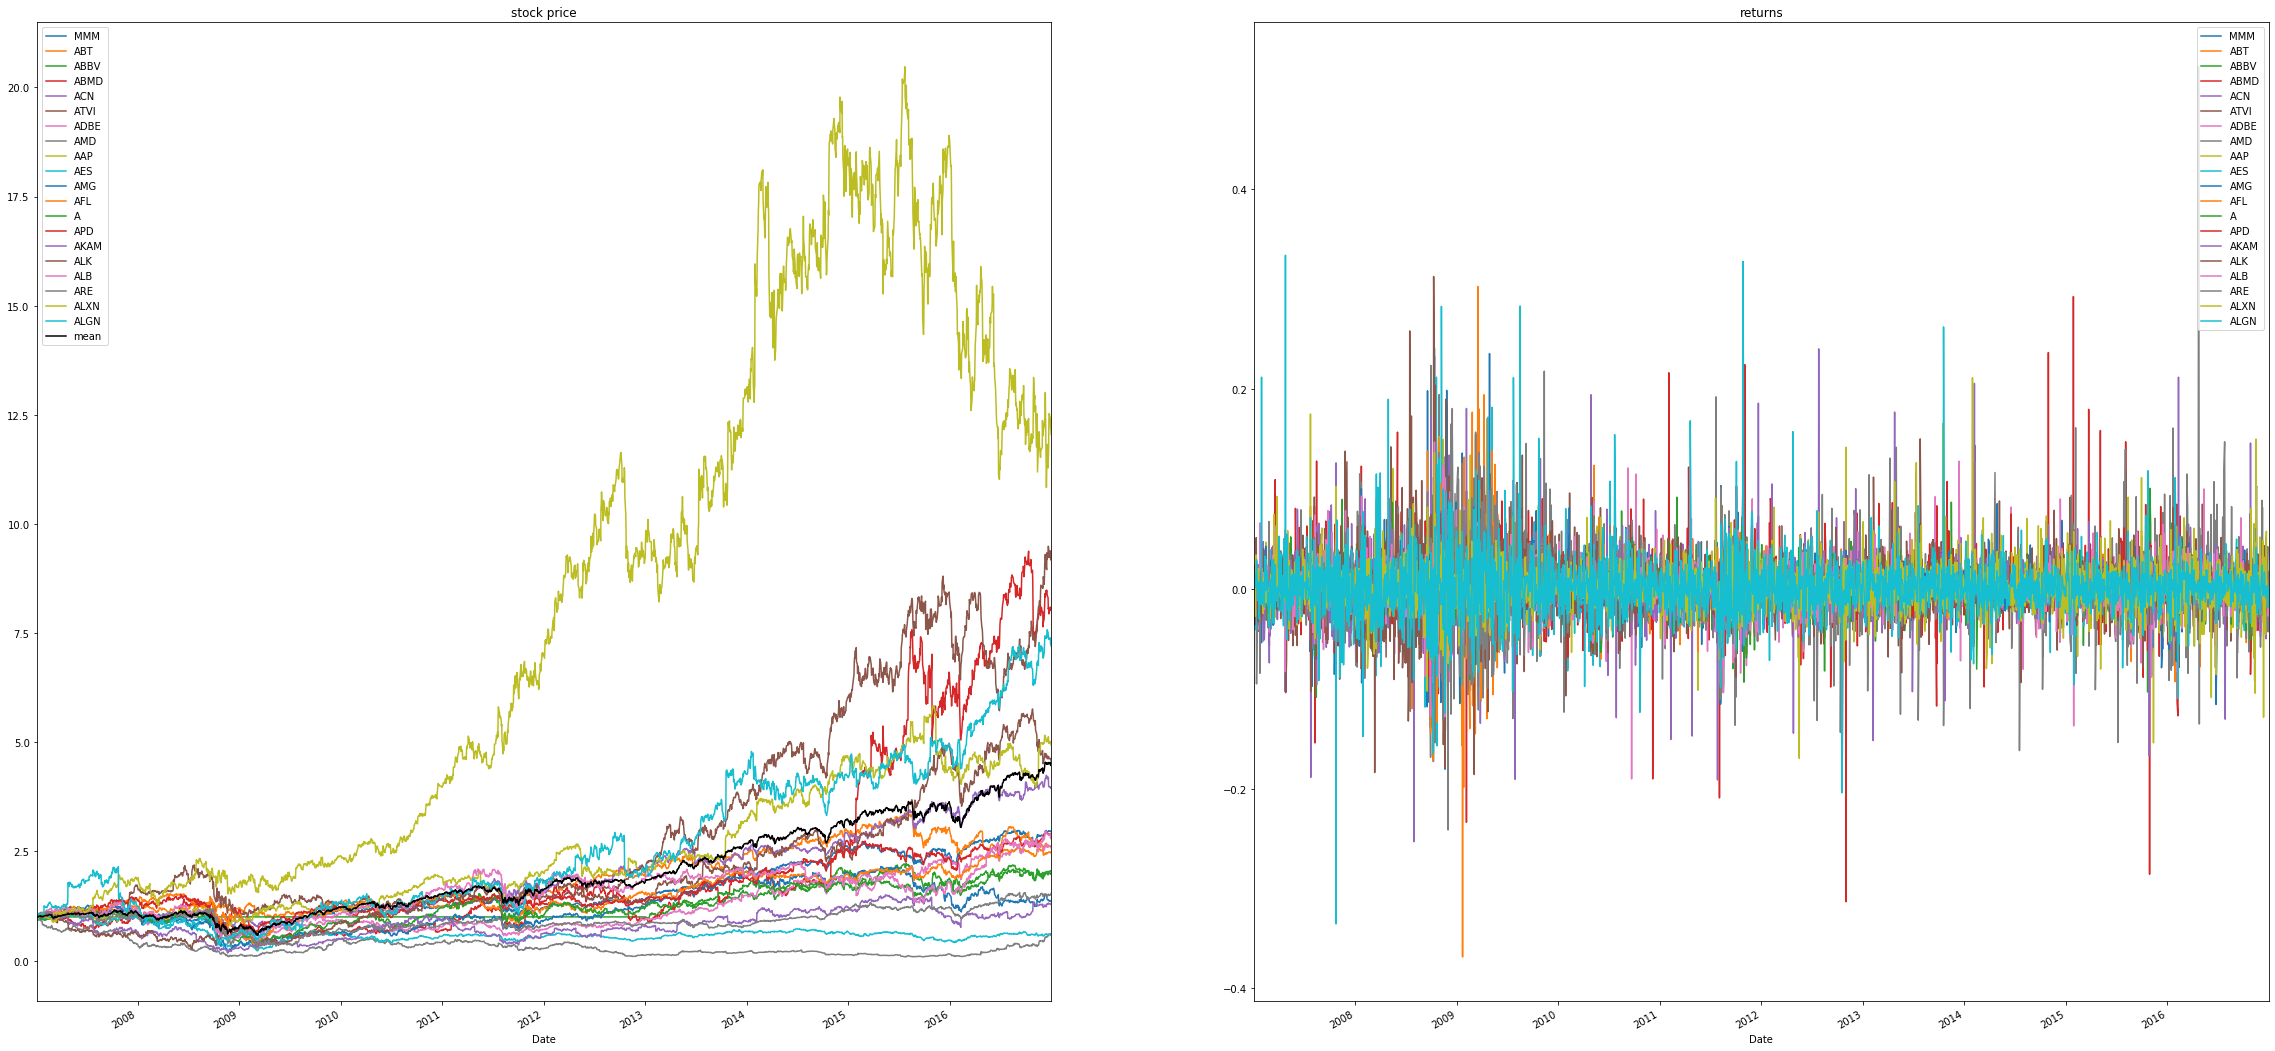

In [7]:
delete_nans('returns.csv', 'returns.csv')
plot_example_returns('returns.csv', N)

## Calculations 

In [132]:
def cnn(x_train, y_train, x_test, y_test, inp_shape):
    verbose, epochs, batch_size = 1,1000, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    N = inp_shape[1]
    #init
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu',
                     input_shape=inp_shape))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    #Conv1D => 1D Convolution (Schaut nach Mustern)
    #mit filters = Anzahl Weight Functions, kernel_size = Anzahl simultan betrachteter Felder, 
    #relu = 0 für value<0 sonst linear
    
    model.add(layers.Dropout(0.5))
    #Dropout sets randomly chosen values to 0 to prevent overfitting
    
    model.add(layers.MaxPooling1D(pool_size=2))
    #MaxPooling halbiert array Größe und nimmt größte Werte der Feature-Gewichtungen 
    
    model.add(layers.Flatten())
    #Flatten reduziert dimensionen eines arrays auf niedrigst mögliche Dimension (1xdim) (überschreibt Nullen))
    
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(N, activation='linear'))
    #Klassisches NN hinter Convolutional Layer geschaltet, lernt also im Feature Raum, durch Convolutional Net vorgebenen
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
    
    #fit network
    model.fit(x_train,y_train, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(x_test,y_test, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model
    

In [117]:
def fully(x_train,y_train,x_test,y_test,inp_shape):
    verbose, epochs, batch_size = 1, 1000, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    N = inp_shape[1]
    #init
    model = models.Sequential()
    model.add(layers.Dense(100, activation='tanh'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(.1))
    model.add(layers.Dense(100, activation='tanh'))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(N, activation='linear'))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
    
    #fit network
    model.fit(x_train,y_train, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(x_test,y_test, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model
    

In [85]:
def rnn(x_train, y_train, x_test, y_test, inp_shape):
    verbose, epochs, batch_size = 1, 1000, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    N = inp_shape[1]
    #init
    model = models.Sequential()
    model.add(layers.GRU(42, input_shape = inp_shape, return_sequences = True))
    model.add(layers.Dropout(0.2))
    model.add(layers.GRU(42, return_sequences = False))
    
    #Dropout sets randomly chosen values to 0 to prevent overfitting
    
    #model.add(layers.MaxPooling1D(pool_size=2))
    #MaxPooling halbiert array Größe und nimmt größte Werte der Feature-Gewichtungen 
    
    #model.add(layers.Flatten())
    #Flatten reduziert dimensionen eines arrays auf niedrigst mögliche Dimension (1xdim) (überschreibt Nullen))
    
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(N, activation='linear'))
    #Klassisches NN hinter Convolutional Layer geschaltet, lernt also im Feature Raum, durch Convolutional Net vorgebenen
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
    
    #fit network
    model.fit(x_train,y_train, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(x_test,y_test, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model
    

Die Funktion get_data_subsets unterteilt die Matrix in eine Matrix der Dimension dur x N (Zeitfenster x Stocks) und korrespondierender Vektor für den Tag darauf (dur=1 x stocks). Jedes Matrix-Vektor Paar stellt einen Input plus Target Output(Label, Lösung) dar.

In [11]:
def main(input_df, dur, limit):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    """

    N = input_df.shape[1]
    D = input_df.shape[0]
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets(train, dur) 
    x_test,y_test = get_data_subsets(test, dur)
    inp_shape = (x_train.shape[1],N)
    
    """für Dimensions-tests"""
    print('x-train shape: ' + str(x_train.shape))
    print('y-train shape: ' + str(y_train.shape))
    print('x-test shape: ' + str(x_test.shape))
    print('y-test shape: ' + str(y_test.shape))
    print('test shape: ' + str(test.shape))
    
    model = cnn(x_train, y_train, x_test, y_test, inp_shape)
    return model,x_train,y_train,x_test,y_test

In [12]:
def main_fully_connected(input_df, dur, limit):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    """

    N = input_df.shape[1]
    D = input_df.shape[0]
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets(train, dur) 
    x_test,y_test = get_data_subsets(test, dur)
    inp_shape = (x_train.shape[1],N)
    
    """für Dimensions-tests"""
    print('x-train shape: ' + str(x_train.shape))
    print('y-train shape: ' + str(y_train.shape))
    print('x-test shape: ' + str(x_test.shape))
    print('y-test shape: ' + str(y_test.shape))
    print('test shape: ' + str(test.shape))
    
    model = fully(x_train, y_train, x_test, y_test, inp_shape)
    return model,x_train,y_train,x_test,y_test

In [13]:
def main_rnn(input_df, dur, limit):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    """

    N = input_df.shape[1]
    D = input_df.shape[0]
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets(train, dur) 
    x_test,y_test = get_data_subsets(test, dur)
    inp_shape = (x_train.shape[1],N)
    
    """für Dimensions-tests"""
    print('x-train shape: ' + str(x_train.shape))
    print('y-train shape: ' + str(y_train.shape))
    print('x-test shape: ' + str(x_test.shape))
    print('y-test shape: ' + str(y_test.shape))
    print('test shape: ' + str(test.shape))
    
    model = rnn(x_train, y_train, x_test, y_test, inp_shape)
    return model,x_train,y_train,x_test,y_test

In [87]:
model_rnn,x_train,y_train,x_test,y_test = main_rnn(returns, 100, 2000)

1900
518
x-train shape: (1900, 109, 20)
y-train shape: (1900, 20)
x-test shape: (518, 109, 20)
y-test shape: (518, 20)
test shape: (618, 20)
Epoch 1/40
1900/1900 [==============================] - 18s 9ms/step - loss: 6.4690e-04 - mse: 6.4690e-04 - mae: 0.0161
Epoch 2/40
1900/1900 [==============================] - 16s 8ms/step - loss: 6.3931e-04 - mse: 6.3931e-04 - mae: 0.0159
Epoch 3/40
1900/1900 [==============================] - 16s 8ms/step - loss: 6.3708e-04 - mse: 6.3708e-04 - mae: 0.0159
Epoch 4/40
1900/1900 [==============================] - 16s 9ms/step - loss: 6.3603e-04 - mse: 6.3603e-04 - mae: 0.0159
Epoch 5/40
1900/1900 [==============================] - 16s 8ms/step - loss: 6.3928e-04 - mse: 6.3928e-04 - mae: 0.0160
Epoch 6/40
1900/1900 [==============================] - 16s 8ms/step - loss: 6.3225e-04 - mse: 6.3225e-04 - mae: 0.0159
Epoch 7/40
1900/1900 [==============================] - 17s 9ms/step - loss: 6.3280e-04 - mse: 6.3280e-04 - mae: 0.0159
Epoch 8/40
1900/190

In [81]:
model_cnn,x_train,y_train,x_test,y_test = main(returns, 100, 2000)

1900
518
x-train shape: (1900, 109, 20)
y-train shape: (1900, 20)
x-test shape: (518, 109, 20)
y-test shape: (518, 20)
test shape: (618, 20)
Epoch 1/40
1900/1900 [==============================] - 2s 938us/step - loss: 7.8351e-04 - mse: 7.8351e-04 - mae: 0.0179
Epoch 2/40
1900/1900 [==============================] - 2s 927us/step - loss: 6.3890e-04 - mse: 6.3890e-04 - mae: 0.0159
Epoch 3/40
1900/1900 [==============================] - 2s 928us/step - loss: 6.3913e-04 - mse: 6.3913e-04 - mae: 0.0159
Epoch 4/40
1900/1900 [==============================] - 2s 873us/step - loss: 6.3931e-04 - mse: 6.3931e-04 - mae: 0.0159
Epoch 5/40
1900/1900 [==============================] - 1s 760us/step - loss: 6.3992e-04 - mse: 6.3992e-04 - mae: 0.0159
Epoch 6/40
1900/1900 [==============================] - 2s 865us/step - loss: 6.3889e-04 - mse: 6.3889e-04 - mae: 0.0159
Epoch 7/40
1900/1900 [==============================] - 2s 814us/step - loss: 6.3783e-04 - mse: 6.3783e-04 - mae: 0.0159
Epoch 8/40
1

In [118]:
model_fully,x_train,y_train,x_test,y_test = main_fully_connected(returns, 100, 2000)

1900
518
x-train shape: (1900, 109, 20)
y-train shape: (1900, 20)
x-test shape: (518, 109, 20)
y-test shape: (518, 20)
test shape: (618, 20)
Epoch 1/40
1900/1900 [==============================] - 3s 2ms/step - loss: 9.3236e-04 - mse: 9.3236e-04 - mae: 0.0185
Epoch 2/40
1900/1900 [==============================] - 3s 2ms/step - loss: 6.3844e-04 - mse: 6.3844e-04 - mae: 0.0159A: 1s - loss: 6.2837e-04 - mse:
Epoch 3/40
1900/1900 [==============================] - 3s 2ms/step - loss: 6.3950e-04 - mse: 6.3950e-04 - mae: 0.0159
Epoch 4/40
1900/1900 [==============================] - 3s 1ms/step - loss: 6.3880e-04 - mse: 6.3880e-04 - mae: 0.0159
Epoch 5/40
1900/1900 [==============================] - 3s 1ms/step - loss: 6.3883e-04 - mse: 6.3883e-04 - mae: 0.0159
Epoch 6/40
1900/1900 [==============================] - 3s 2ms/step - loss: 6.3917e-04 - mse: 6.3917e-04 - mae: 0.0159
Epoch 7/40
1900/1900 [==============================] - 3s 2ms/step - loss: 6.3877e-04 - mse: 6.3877e-04 - mae: 0.

In [17]:
print(model_fully.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 109, 100)          2100      
_________________________________________________________________
dense_6 (Dense)              (None, 109, 100)          10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 109, 100)          0         
_________________________________________________________________
dense_7 (Dense)              (None, 109, 100)          10100     
_________________________________________________________________
flatten_2 (Flatten)          (None, 10900)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               1090100   
_________________________________________________________________
dense_9 (Dense)              (None, 20)               

In [18]:
print(model_cnn.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 107, 64)           3904      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 105, 64)           12352     
_________________________________________________________________
dropout_2 (Dropout)          (None, 105, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 52, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3328)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               332900    
_________________________________________________________________
dense_4 (Dense)              (None, 20)               

In [19]:
print(model_rnn.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 109, 42)           7938      
_________________________________________________________________
dropout_1 (Dropout)          (None, 109, 42)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 42)                10710     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               4300      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
Total params: 24,968
Trainable params: 24,968
Non-trainable params: 0
_________________________________________________________________
None


### Tests 

Function to check wether stock value changes were recognised to increase/decrease correctly

In [20]:
def directional_goodness(model,x_new,y_new):
    """
    directional goodnes gives the factor of correctly predicted signs of first order derivative of returns to false ones
    oder auch: 
    gibt die Anzahl der Beobachtungen an, deren Vorhersage das richtige Vorzeichen hatte (Kurs steigt, Kurs fällt)
    """
    y_pred = model.predict(x_new)
    count = 0
    #print(y_new.shape)
    for i in range(len(y_pred)):
        for j in range(len(y_pred[i])):
            p= y_pred[i,j] > 0
            n = y_new[i,j] > 0
            if n==p:
                count +=1
    print('percentage of correctly predicted directions of returns: ' + str(count/len(y_pred)/len(y_pred[0])))

In [21]:
directional_goodness(model_cnn,x_test,y_test)

percentage of correctly predicted directions of returns: 0.502992277992278


In [22]:
directional_goodness(model_cnn,x_train,y_train)

percentage of correctly predicted directions of returns: 0.49850000000000005


In [119]:
directional_goodness(model_fully,x_test,y_test)

percentage of correctly predicted directions of returns: 0.5068532818532818


In [120]:
directional_goodness(model_fully,x_train,y_train)

percentage of correctly predicted directions of returns: 0.5025000000000001


In [25]:
directional_goodness(model_rnn,x_test,y_test)

percentage of correctly predicted directions of returns: 0.49565637065637064


In [26]:
directional_goodness(model_rnn,x_train,y_train)

percentage of correctly predicted directions of returns: 0.5077631578947368


Function to check internal goodness - predicted values vs actual measured values used for training

In [27]:
def internal_goodness(model, x_new, y_new):
    print('compare true to predicted values of internal validation on learned dataset: ')
    y_pred = model.predict(x_new)
    #model.predict nimmt x-werte und gibt die predicteten y-werte zurück
    plt.scatter(y_new, y_pred)

compare true to predicted values of internal validation on learned dataset: 


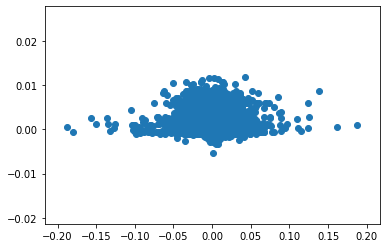

In [116]:
internal_goodness(model_cnn,x_test,y_test)

compare true to predicted values of internal validation on learned dataset: 


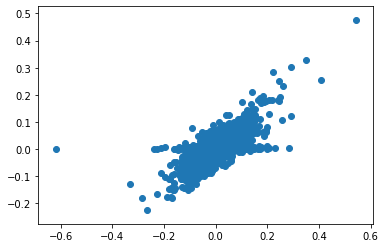

In [89]:
internal_goodness(model_cnn,x_train,y_train)

compare true to predicted values of internal validation on learned dataset: 


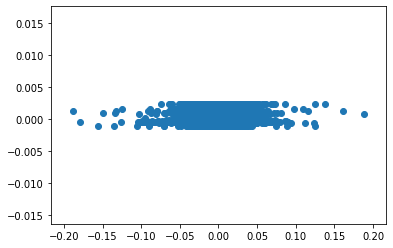

In [121]:
internal_goodness(model_fully,x_test,y_test)

compare true to predicted values of internal validation on learned dataset: 


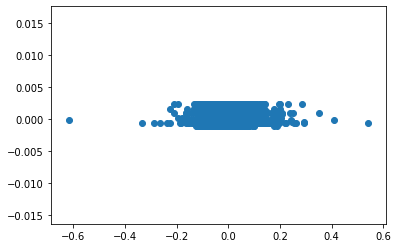

In [122]:
internal_goodness(model_fully,x_train,y_train)

compare true to predicted values of internal validation on learned dataset: 


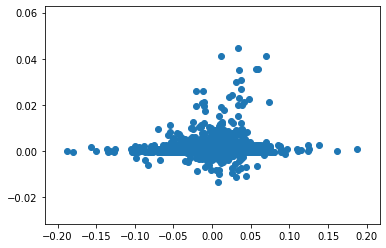

In [123]:
internal_goodness(model_rnn,x_test,y_test)

compare true to predicted values of internal validation on learned dataset: 


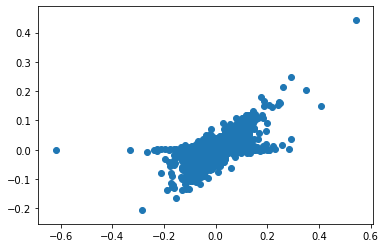

In [93]:
internal_goodness(model_rnn,x_train,y_train)

Function to check external goodness - predicted values for future data vs actual future data

In [49]:
def external_goodness(model, x_new, y_new):
    print('compare true to predicted values of external validation set: ')
    y_pred = model.predict(x_new)
    color =  ["r", "b", "g"]
    for i in range(3):
        plt.plot(y_new[:30,i],c=color[i], label = 'true')
        plt.plot(y_pred[:30,i], c=color[i], linestyle='--', label = 'pred')
    plt.legend()

compare true to predicted values of external validation set: 


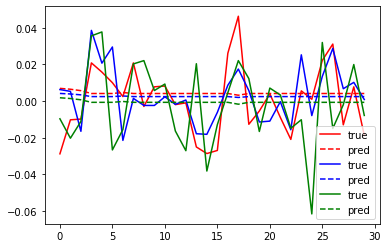

In [106]:
external_goodness(model_cnn,x_test,y_test)

compare true to predicted values of external validation set: 


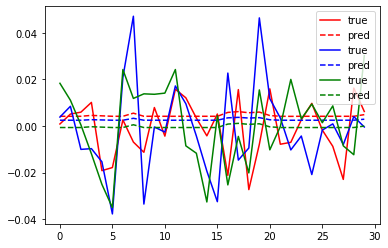

In [107]:
external_goodness(model_cnn,x_train,y_train)

compare true to predicted values of external validation set: 


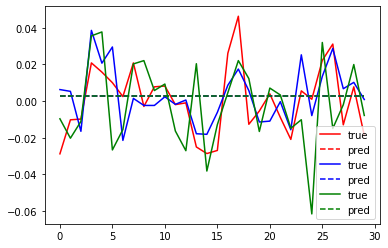

In [108]:
external_goodness(model_fully,x_test,y_test)

compare true to predicted values of external validation set: 


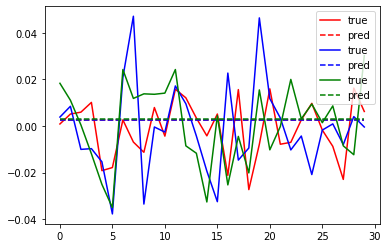

In [109]:
external_goodness(model_fully,x_train,y_train)

compare true to predicted values of external validation set: 


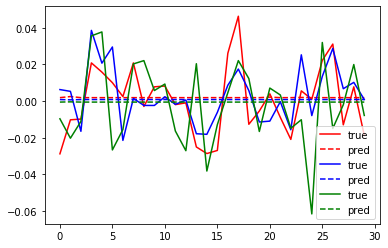

In [110]:
external_goodness(model_rnn,x_test,y_test)

compare true to predicted values of external validation set: 


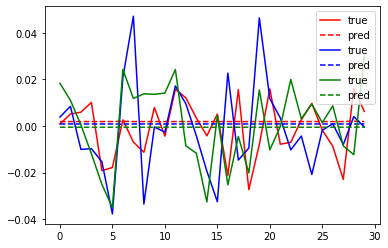

In [111]:
external_goodness(model_rnn,x_train,y_train)

In [112]:
x_test2 = x_test.copy()

In [113]:
for i in range(1,20):
    x_test2[:,:,i] = x_test[:,:,0]

compare true to predicted values of external validation set: 


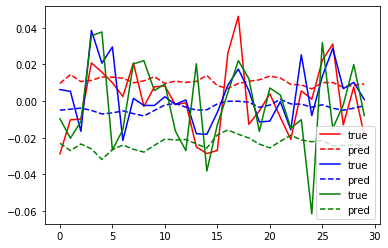

In [114]:
external_goodness(model_cnn, x_test2,y_test)

In [59]:
def largest(array, amount):
    return array.argsort()[:,-amount:]

In [60]:
def compare_top(model, x_test, y_test):
    amount = 5
    mean_all = np.mean(y_test)
    y_pred = model.predict(x_test)
    top_index = largest(y_pred,amount)
    mean_mach = np.mean(y_test[top_index])
    return mean_mach-mean_all

In [103]:
compare_top(model_cnn, x_test, y_test)

-0.007148576123087615

In [104]:
compare_top(model_fully, x_test, y_test)

0.00042525057063283326

In [105]:
compare_top(model_rnn, x_test, y_test)

-0.0023363514279325214